In [1]:
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch
from kan import *

# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[4,5,2], grid=5, k=3, seed=0)

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 读取xlsx文件
file_path = 'D:\OneDrive - Officials\OneDrive - Mraz Cindy\done\毕设资料\计算公式说明\数据库.xlsx'  # 替换为你的xlsx文件路径
df = pd.read_excel(file_path, engine='openpyxl')

# 打乱行顺序并按8:2的比例分成训练集和测试集
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# 输出结果
print("训练集样本数:", len(train_df))
print("测试集样本数:", len(test_df))

训练集样本数: 307
测试集样本数: 77


In [3]:
# 提取第2，3，4，5列的数据
input = train_df.iloc[:, 1:5]
output = train_df.iloc[:, 5:7]
test_input = test_df.iloc[:, 1:5]
test_label = test_df.iloc[:, 5:7]
# 将DataFrame转换为numpy数组并调整其维度为4
array1 = input.to_numpy()
array2 = output.to_numpy()
array3 = test_input.to_numpy()
array4 = test_label.to_numpy()
input=torch.tensor(array1, dtype=torch.float32)
ouput=torch.tensor(array2, dtype=torch.float32)
test_input=torch.tensor(array3, dtype=torch.float32)
test_label=torch.tensor(array4, dtype=torch.float32)
def normalize_columns(tensor):
    # 确保输入是2D张量
    assert tensor.dim() == 2, "Input tensor must be 2D"
    
    # 获取最小值和最大值
    col_min = tensor.min(dim=0, keepdim=True).values
    col_max = tensor.max(dim=0, keepdim=True).values
    
    # 防止除以零的情况
    denom = col_max - col_min
    denom[denom == 0] = 1  # 如果列中所有值相等，避免除以零
    
    # 进行归一化
    normalized_tensor = (tensor - col_min) / denom
    return normalized_tensor
# 对每一列进行归一化
input= normalize_columns(input)
ouput= normalize_columns(ouput)
test_input= normalize_columns(test_input)
test_label= normalize_columns(test_label)
dataset={'train_input':input,'test_input':test_input,'train_label':ouput,'test_label':test_label}

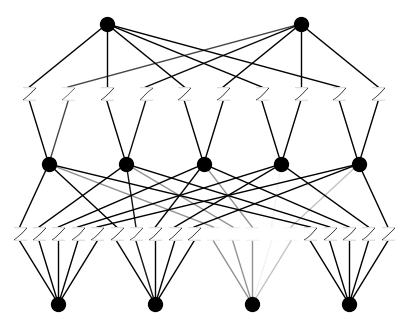

In [4]:
model(input)
model.plot(beta=100)

train loss: 2.51e-01 | test loss: 2.89e-01 | reg: 6.82e+01 : 100%|██| 50/50 [00:12<00:00,  3.85it/s]


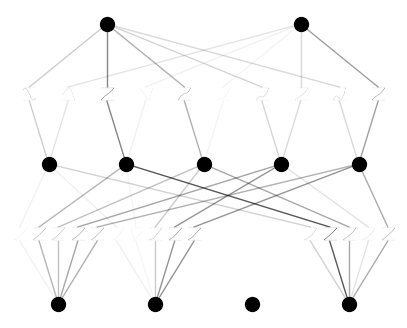

In [5]:
model.train(dataset, opt="LBFGS", steps=50, lamb=0.01, lamb_entropy=10.);
model.plot()

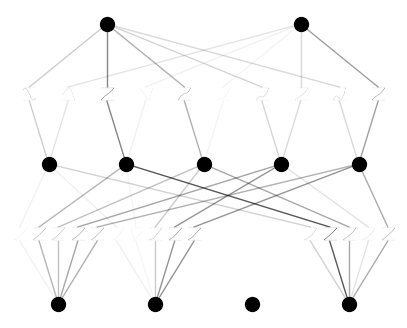

In [6]:
model.prune()
model.plot(mask=True)

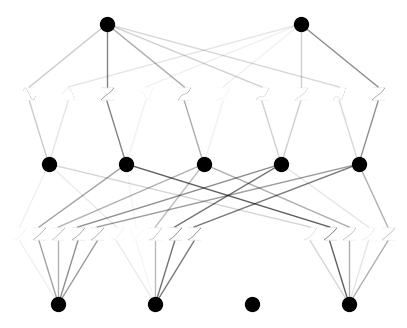

In [7]:
model = model.prune()
model(dataset['train_input'])
model.plot()

In [8]:
model.train(dataset, opt="LBFGS", steps=100);

train loss: 1.67e-02 | test loss: 7.85e-02 | reg: 7.99e+01 : 100%|█| 100/100 [00:54<00:00,  1.83it/s


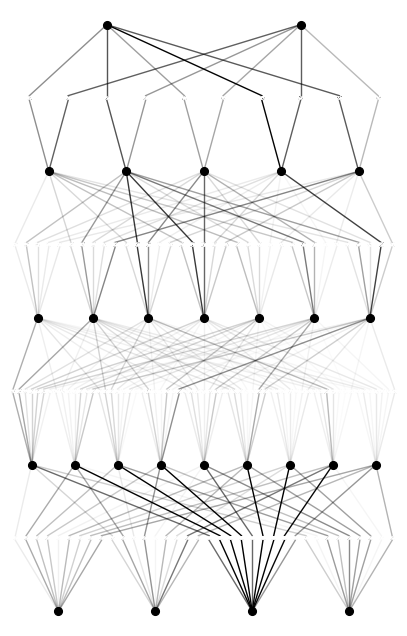

In [9]:
model.plot()

In [10]:
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,0,'sin');
    model.fix_symbolic(0,1,0,'x^2');
    model.fix_symbolic(1,0,0,'exp');
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    model.auto_symbolic(lib=lib)

fixing (0,0,0) with tanh, r2=0.9989561438560486
fixing (0,0,1) with exp, r2=0.9990406632423401
fixing (0,0,2) with sin, r2=0.9991142749786377
fixing (0,0,3) with x^2, r2=0.9993574619293213
fixing (0,0,4) with log, r2=0.9996179938316345
fixing (0,0,5) with tanh, r2=0.9997875690460205
fixing (0,0,6) with sin, r2=0.9996036291122437
fixing (0,0,7) with sin, r2=0.9990439414978027
fixing (0,0,8) with sin, r2=0.9993848204612732
fixing (0,1,0) with x^4, r2=1.0000004768371582
fixing (0,1,1) with exp, r2=1.0000005960464478
fixing (0,1,2) with x^4, r2=1.0000004768371582
fixing (0,1,3) with x^4, r2=1.0000007152557373
fixing (0,1,4) with exp, r2=1.0000005960464478
fixing (0,1,5) with exp, r2=1.0000007152557373
fixing (0,1,6) with exp, r2=1.0000005960464478
fixing (0,1,7) with x^2, r2=1.0000008344650269
fixing (0,1,8) with exp, r2=1.0000007152557373
fixing (0,2,0) with abs, r2=0.0
fixing (0,2,1) with abs, r2=0.0
fixing (0,2,2) with exp, r2=3.065221157391813e-18
fixing (0,2,3) with abs, r2=0.0
fixing

In [11]:
model.train(dataset, opt="LBFGS", steps=50);

description:   0%|                                                           | 0/50 [00:00<?, ?it/s]


RuntimeError: false INTERNAL ASSERT FAILED at "..\\aten\\src\\ATen\\native\\BatchLinearAlgebra.cpp":1538, please report a bug to PyTorch. torch.linalg.lstsq: (Batch element 4): Argument 4 has illegal value. Most certainly there is a bug in the implementation calling the backend library.

In [12]:
model.symbolic_formula()

make sure all activations need to be converted to symbolic formulas first!


## 优化参数

In [22]:
import numpy as np
import torch
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error


def cross_val_score(model, dataset, params, k_folds=5):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    scores = []

    for train_index, val_index in kf.split(dataset['train_input']):
        train_input = dataset['train_input'][train_index]
        train_label = dataset['train_label'][train_index]
        val_input = dataset['train_input'][val_index]
        val_label = dataset['train_label'][val_index]

        train_data = {
            'train_input': torch.tensor(train_input, dtype=torch.float32),
            'train_label': torch.tensor(train_label, dtype=torch.float32),
            'test_input': torch.tensor(val_input, dtype=torch.float32),
            'test_label': torch.tensor(val_label, dtype=torch.float32),
        }

        model.train(train_data, **params)

        val_pred = model.forward(torch.tensor(val_input, dtype=torch.float32))
        val_score = mean_squared_error(val_label, val_pred.detach().numpy())
        scores.append(val_score)

    return np.mean(scores)

# Define parameter grid
param_grid = {
    'lamb': [0.1, 0.5, 1.0],
    'lamb_l1': [0.01, 0.05, 0.1],
    'lamb_entropy': [0.01, 0.05, 0.1],
    'lamb_coef': [0.01, 0.05, 0.1],
    'lamb_coefdiff': [0.01, 0.05, 0.1],
    'small_mag_threshold': [1e-16, 1e-15, 1e-14],
    'small_reg_factor': [0.1, 0.5, 1.0]
}

# Create dataset (example)
dataset = {
    'train_input': np.random.rand(100, 10),
    'train_label': np.random.rand(100, 1),
    'test_input': np.random.rand(20, 10),
    'test_label': np.random.rand(20, 1)
}

# Initialize model
model = model.prune()

# Perform grid search
best_score = float('inf')
best_params = None

from itertools import product

for lamb, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff, small_mag_threshold, small_reg_factor in product(
    param_grid['lamb'],
    param_grid['lamb_l1'],
    param_grid['lamb_entropy'],
    param_grid['lamb_coef'],
    param_grid['lamb_coefdiff'],
    param_grid['small_mag_threshold'],
    param_grid['small_reg_factor']
):
    params = {
        'lamb': lamb,
        'lamb_l1': lamb_l1,
        'lamb_entropy': lamb_entropy,
        'lamb_coef': lamb_coef,
        'lamb_coefdiff': lamb_coefdiff,
        'small_mag_threshold': small_mag_threshold,
        'small_reg_factor': small_reg_factor,
        'opt': 'Adam',  # Example optimizer
        'steps': 100,  # Example steps
        'log': 10,  # Example log frequency
        'update_grid': True,
        'grid_update_num': 10,
        'stop_grid_update_step': 50,
        'batch': -1,
        'device': 'cpu',
        'save_fig_freq': 1
    }

    score = cross_val_score(model, dataset, params, k_folds=5)
    if score < best_score:
        best_score = score
        best_params = params

print(f"Best Score: {best_score}")
print("Best Parameters:")
print(best_params)
 

AttributeError: 'KAN' object has no attribute 'acts_scale'